# Wine Grape Variety Recognition 

In [1]:
import csv
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import pandas as pd

## Data Processing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/EngSci 2T1 + PEY/Year 4/Summer/APS360/Project

/content/gdrive/MyDrive/EngSci 2T1 + PEY/Year 4/Summer/APS360/Project


In [4]:
header = ['Index', 'Description', 'Variety']
df = pd.read_csv("wine-data_10k_2001.csv", names=header, index_col=False)
df = df[['Description', 'Variety']][1:]

In [5]:
df.shape

(10939, 2)

In [6]:
variety_count = df['Variety'].value_counts()
to_remove = variety_count[variety_count < 88].index
df = df[~df.Variety.isin(to_remove)]

In [7]:
df.shape

(9226, 2)

In [8]:
df['Variety'].value_counts()

Pinot Noir                    1241
Bordeaux-style Red Blend      1080
Chardonnay                     820
Red Blends                     797
Cabernet Sauvignon             574
Sangiovese                     516
Rhône-style Red Blend          477
Syrah                          420
Riesling                       409
Gamay                          375
Rosé                           330
Sauvignon Blanc                264
Portuguese Red                 214
Malbec                         194
Merlot                         168
Sparkling Blend                157
Bordeaux-style White Blend     155
Zinfandel                      151
Rhône-style White Blend        145
Grüner Veltliner               143
Cabernet Franc                 120
Tempranillo                    106
Grenache                       103
Nebbiolo                        91
Portuguese White                88
White Blend                     88
Name: Variety, dtype: int64

In [9]:
variety_values = df['Variety'].unique()

def get_variety_onehot_from_value(value):
    onehot = np.zeros(26)
    onehot[np.where(variety_values == value)] = 1
    return onehot

def get_variety_label(value):
    return np.where(get_variety_onehot_from_value(value) == 1)[0]

def get_variety_onehot_from_label(label):
    onehot = np.zeros(26)
    onehot[round(label)] = 1
    return onehot

def get_variety_value(label):
    return variety_values[np.argmax(get_variety_onehot_from_label(label))]

In [10]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

def split_word(review):
    # separate punctuations
    review = review.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return review.lower().split()

### CNN

Input word vectors with constant dimensions of 50.

In [11]:
def get_word_vectors_cnn(glove_vector):
    i = 0
    train, valid, test = [], [], []
    for line in df.values:
        review = line[0]
        if i < 5000:
            word_emb = sum(glove_vector[w] for w in split_word(review))
            label = torch.tensor(get_variety_onehot(line[1]), dtype=torch.float32)
            if i % 10 < 8:
                train.append((word_emb, label)) # 80% training
            elif i % 10 == 9:
                valid.append((word_emb, label)) # 10% validation
            else:
                test.append((word_emb, label)) # 10% test
        i += 1
    return train, valid, test

In [ ]:
train, valid, test = get_word_vectors_cnn(glove)

print("The number of entries in the training set is", len(train))
print("The number of entries in the validation set is", len(valid))
print("The number of entries in the test set is", len(test))

The number of entries in the training set is 4000
The number of entries in the validation set is 500
The number of entries in the test set is 500


In [ ]:
for i in range(5):
    review, label = train[i]
    print(review.shape)
    print(label)
    print()

torch.Size([50])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])



### RNN & LSTM

Input word vectors with variable dimensions. 

In [11]:
def get_word_vectors_rnn(glove_vector):
    i = 0
    train, valid, test = [], [], []
    for line in df.values:
        review = line[0]
        if i < 9226:
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_word(review)
                    if w in glove_vector.stoi]  # keep words that has an embedding
            if not idxs:                        # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs)           # convert list to pytorch tensor
            label = torch.tensor(get_variety_label(line[1])).long()
            if i % 10 < 8:
                train.append((idxs, label))
            elif i % 10 == 9:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
        i += 1
    return train, valid, test

In [12]:
train, valid, test = get_word_vectors_rnn(glove)

print("The number of entries in the training set is", len(train))
print("The number of entries in the validation set is", len(valid))
print("The number of entries in the test set is", len(test))

The number of entries in the training set is 7382
The number of entries in the validation set is 922
The number of entries in the test set is 922


In [13]:
for i in range(5):
    review, label = train[i]
    print(review.shape)
    print(label)
    print()

torch.Size([61])
tensor([0])

torch.Size([62])
tensor([0])

torch.Size([64])
tensor([0])

torch.Size([61])
tensor([1])

torch.Size([51])
tensor([2])



## Model Setup

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0, c0))
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

## Training

In [15]:
import random

class ReviewBatcher:
    def __init__(self, reviews, batch_size=32, drop_last=False):
        self.words_by_length = {}
        for words, label in reviews:
            wlen = words.shape[0]
            if wlen not in self.words_by_length:
                self.words_by_length[wlen] = []
            self.words_by_length[wlen].append((words, label),)
         
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    reviews,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last)
            for wlen, reviews in self.words_by_length.items()}
        
    def __iter__(self): 
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

In [16]:
def get_val_loss(model, valid_loader, criterion):
    total_val_loss = 0.0
    i = 0
    for reviews, labels in train_loader:
        pred = model(reviews)
        loss = criterion(pred, labels.squeeze())
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/(i + 1)
    return val_loss

In [17]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for reviews, labels in data_loader:
        output = model(reviews)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [18]:
def train_RNN(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(1000)          
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    epochs = []

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        i = 0
        for reviews, labels in train_loader:
            optimizer.zero_grad()
            pred = model(reviews)
            loss = criterion(pred, labels.squeeze())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            i += 1
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        train_loss.append(float(total_train_loss)/(i + 1))
        val_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(get_val_loss(model, valid_loader, criterion))
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[-1],
                   train_loss[-1],
                   val_acc[-1],
                   val_loss[-1]))
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.34073795180722893, Train loss: 2.686487819467272 |Validation acc: 0.31453362255965295, Validation loss: 2.354003517400651
Epoch 2: Train acc: 0.4348644578313253, Train loss: 2.2017284347897483 |Validation acc: 0.3947939262472885, Validation loss: 1.9019984702269237
Epoch 3: Train acc: 0.5111069277108434, Train loss: 1.8735063260509854 |Validation acc: 0.4544468546637744, Validation loss: 1.6755728054614294
Epoch 4: Train acc: 0.5353915662650602, Train loss: 1.689340977441697 |Validation acc: 0.49023861171366595, Validation loss: 1.542491322471982
Epoch 5: Train acc: 0.572289156626506, Train loss: 1.5797937682696752 |Validation acc: 0.5065075921908894, Validation loss: 1.3932448795863561
Epoch 6: Train acc: 0.5713478915662651, Train loss: 1.4399081397624243 |Validation acc: 0.5032537960954447, Validation loss: 1.3585917027223677
Epoch 7: Train acc: 0.604480421686747, Train loss: 1.378517522698357 |Validation acc: 0.5325379609544468, Validation loss: 1.2821365687109

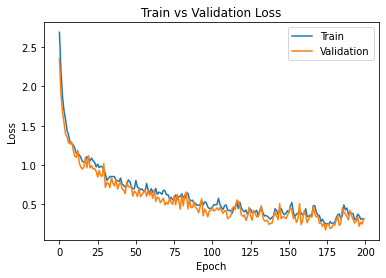

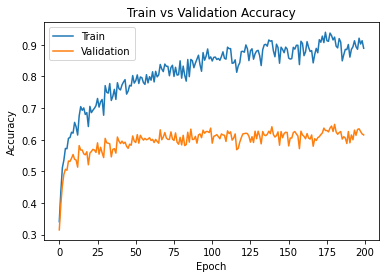

Final Training Accuracy: 0.8893072289156626
Final Validation Accuracy: 0.6149674620390455


In [20]:
model = RNN(50, 200, 26)
train_loader = ReviewBatcher(train, batch_size=64, drop_last=True)
valid_loader = ReviewBatcher(valid, batch_size=64, drop_last=False)
train_RNN(model, train_loader, valid_loader, num_epochs=200, learning_rate=5e-3)

Epoch 1: Train acc: 0.4006024096385542, Train loss: 2.4704124203750064 |Validation acc: 0.37310195227765725, Validation loss: 1.9385166125638145
Epoch 2: Train acc: 0.5608057228915663, Train loss: 1.7301890481086004 |Validation acc: 0.5075921908893709, Validation loss: 1.4707561972595395
Epoch 3: Train acc: 0.6423192771084337, Train loss: 1.3821542135306768 |Validation acc: 0.5585683297180043, Validation loss: 1.1888762336401713
Epoch 4: Train acc: 0.6893825301204819, Train loss: 1.155999814470609 |Validation acc: 0.5997830802603037, Validation loss: 1.0030217206194287
Epoch 5: Train acc: 0.7473644578313253, Train loss: 0.9956460836387816 |Validation acc: 0.631236442516269, Validation loss: 0.8438452283541361
Epoch 6: Train acc: 0.7921686746987951, Train loss: 0.8324896838693392 |Validation acc: 0.6529284164859002, Validation loss: 0.687576715080511
Epoch 7: Train acc: 0.8413027108433735, Train loss: 0.7104325677667346 |Validation acc: 0.6681127982646421, Validation loss: 0.56839628162

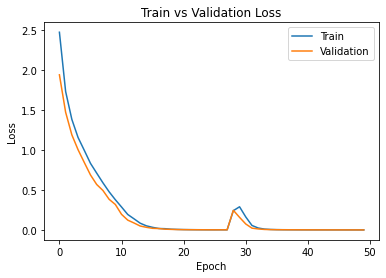

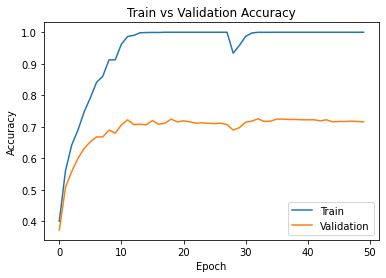

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7158351409978309


In [33]:
model_lstm = LSTM(50, 200, 26)
train_RNN(model_lstm, train_loader, valid_loader, num_epochs=50, learning_rate=5e-3)

## Testing

In [28]:
test_loader = ReviewBatcher(test, batch_size=64, drop_last=False)   
test_acc_rnn = get_accuracy(model, test_loader)       
print("The final test accuracy of my RNN model is", test_acc_rnn*100, "%")      

The final test accuracy of my RNN model is 61.82212581344903 %


In [34]:
test_acc_lstm = get_accuracy(model_lstm, test_loader)       
print("The final test accuracy of my LSTM model is", test_acc_lstm*100, "%")   

The final test accuracy of my LSTM model is 71.90889370932754 %
